In [ ]:
from google.colab.patches import cv2_imshow # for image display
import numpy as np
import pandas as pd
import cv2
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import imutils
from skimage.measure import label, regionprops, regionprops_table

2. Mosaïque d’images. Réaliser une image panoramique à partir d’une
séquence d’images (voir exemple ci-dessous). Assurer que la mosaïque se
fait sans trou.

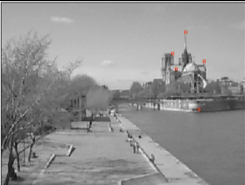

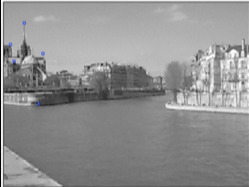

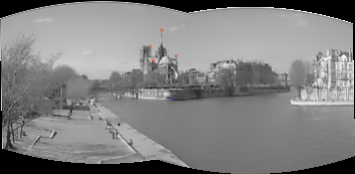

In [ ]:
#loading image
left_img = io.imread('/content/Mosaic_1.png')
right_img = io.imread('/content/Mosaic_2.png')

# converting to RGB
left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

#showing image
# cv2_imshow(left_img)
# cv2_imshow(right_img)

# instantiating sticher
stitcher = cv2.Stitcher_create()

# getting list with images to merge. Will be input of final function
images = []
images.append(left_img)
images.append(right_img)

# merge images
(status, stitched) = stitcher.stitch(images)

# show result
cv2_imshow(left_img)
cv2_imshow(right_img)
cv2_imshow(stitched)

3. Re-focalisation d’une image à partir d’une séquence. Le problème consiste à
construire une image focalisée en tout point à partir d’une séquence de
photos représentant la même scène, partiellement focalisée. Proposer et
implémenter une solution.

image1


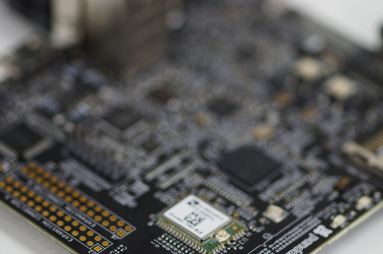

image2


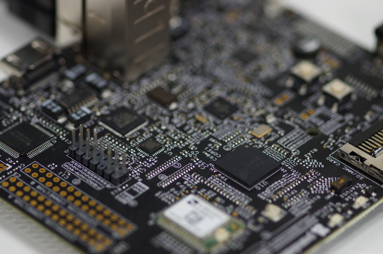

image3


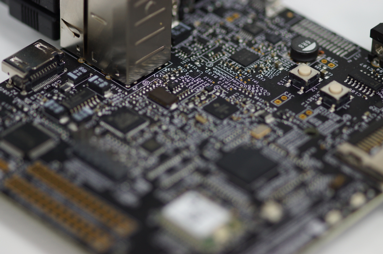

image after recontruction


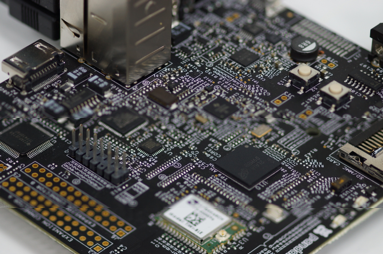

In [ ]:
#loading image
refocus1 = io.imread('/content/Refocus_1.png')
refocus2 = io.imread('/content/Refocus_2.png')
refocus3 = io.imread('/content/Refocus_3.png')

# converting to RGB
refocus1 = cv2.cvtColor(refocus1, cv2.COLOR_BGR2RGB)
refocus2 = cv2.cvtColor(refocus2, cv2.COLOR_BGR2RGB)
refocus3 = cv2.cvtColor(refocus3, cv2.COLOR_BGR2RGB)

# show images availables
print("image1")
cv2_imshow(refocus1)
print("image2")
cv2_imshow(refocus2)
print("image3")
cv2_imshow(refocus3)

# create empty image to store final image
final_image = np.zeros(np.shape(refocus1))

# iterate over each row of pixels
for i in range(len(refocus1[:,:,:])):
    # get standard deviations for every layer of every image available
    refocus1_slice_std = np.std(refocus1[i,:,0])+np.std(refocus1[i,:,1])+np.std(refocus1[i,:,2])
    refocus2_slice_std = np.std(refocus2[i,:,0])+np.std(refocus2[i,:,1])+np.std(refocus2[i,:,2])
    refocus3_slice_std = np.std(refocus3[i,:,0])+np.std(refocus3[i,:,1])+np.std(refocus3[i,:,2])

    # get maximum std. dev. of the row from the three images available
    max_std = max(refocus1_slice_std,refocus2_slice_std,refocus3_slice_std)

    # assign to the final image, the row with biggest std, since a blurred image gets smoother and its stds decrease
    if refocus1_slice_std == max_std:
      final_image[i,:,:] = refocus1[i,:,:]
    elif refocus2_slice_std == max_std:
      final_image[i,:,:] = refocus2[i,:,:]
    else:
      final_image[i,:,:] = refocus3[i,:,:]

print("image after recontruction")
cv2_imshow(final_image)

5. Redimensionner une image sans rompre le contenu. Retirer ou insérer un
chemin de pixel dans une image, de sorte que l’opération soit la plus
imperceptible possible. Le principe consiste à trouver un chemin le moins
couteux pour aller d’un point A à un point B en définissant une fonction de
coût (défini à partir du gradient par exemple et utiliser la programmation
dynamique), puis à retirer le chemin de l’image. La figure ci-dessous montre
le résultat après suppression de plusieurs de ces chemins (ex : Resise.png).

In [ ]:
from PIL import Image, ImageFilter
import sys
import os

'''Returns an energy function for processing the image'''
def energy(image):
    return e1(image);

'''Returns a simple gradient map of the image'''
def e1(image):
    kh = ImageFilter.Kernel((3,3), (-1, 0, 1, -1, 0, 1, -1, 0 ,1), 1, 128)
    kv = ImageFilter.Kernel((3,3), (1, 1, 1, 0, 0, 0, -1, -1 , -1), 1, 128)
    
    hFilter = image.filter(kh).point(lambda i : abs(i-128))
    vFilter = image.filter(kv).point(lambda i : abs(i-128))
    
    return Image.blend(hFilter, vFilter, 0.5)

'''Given an energy map, returns all the vertical seams'''
def computeSeams(energyMap):
    (width, height) = energyMap.size
    emap = energyMap.convert('L').load();
    
    costs = [];
    seams = [];
    
    # For each pixel column, compute a seam
    for col in range(0, width):
        currentCol = col
        cost = 0
        seam = [0]
        
        for row in range(1, height):
            # Look which underneath pixel (left, middle or right) has the least energy
            adj = (emap[currentCol-1, row] if (currentCol - 1 >= 0)    else 1000,
                   emap[currentCol  , row],
                   emap[currentCol+1, row] if (currentCol + 1 < width) else 1000)
            
            # Add the energy of the pixel to the total energy of the seam
            eMin = min(adj)
            cost += eMin
            
            # Did we move one pixel down on the left, middle or right ?
            offset = adj.index(eMin) - 1
            currentCol += offset
            
            # We now have a new value for this seam
            seam.append(offset)
        
        # Update the global costs and seams arrays with the computed cost and seam
        costs.append(cost)
        seams.append(seam)
     
    return (costs, seams)


'''Given a filename, resize it by removing n pixels vertically'''
def resize(filename, pixels, partialSave=0):
    
    im = Image.open(filename)
    
    removedSeams = []
    
    for i in range(0, pixels):
        # Load the image
        (width, height) = im.size
        imap = im.load()
        
        # Find the energy map, and the least energy seam
        energyMap = energy(im)
        (costs, seams) = computeSeams(energyMap)
        
        bestSeamIndex = costs.index(min(costs))
        bestSeam = seams[costs.index(min(costs))]
        
        # Resize the image
        newim = Image.new("RGB", (width - 1, height))
        newim.paste(im, (0, 0))
        
        newimmap = newim.load()
        (nwidth, nheight) = newim.size
        
        # ...and remove the least energy seam
        currentCol = bestSeamIndex
        for row in range(0, nheight):
            currentCol += bestSeam[row]
            for col in range(currentCol, nwidth):
                newimmap[col, row] = imap[col + 1, row]
                
        im = newim
        
        # Save partial result if requested
        if partialSave > 0 and (i % partialSave) == 0:
            im.save("resizePartials/pic" + str(i) + ".png")  
        
        # Save removed seam
        removedSeams.append((bestSeamIndex, bestSeam)) 
    
    return (im, removedSeams)

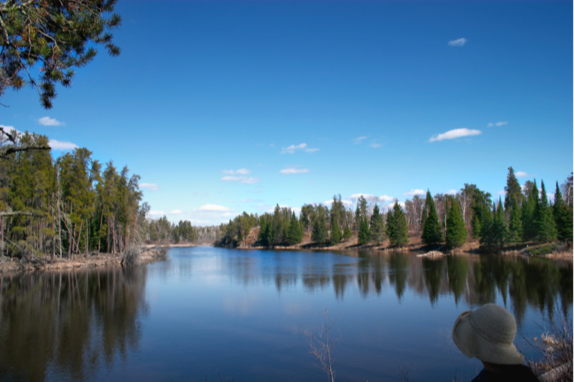

In [ ]:
# cv2_imshow(final_image)
im1 = Image.open("Resize.png")

im1

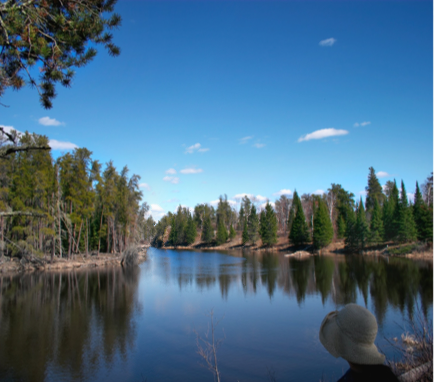

In [ ]:
(im2, removedSeams) = resize("Resize.png", 140)

im2
